In [1]:
import nltk
import spacy
from nltk.corpus import wordnet
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def preprocess_text(text):
    words = []
    doc = nlp(text)

    for tok in doc:
        pos = spacy.explain(tok.pos_)
        dep = tok.dep_

        if pos == "noun" or pos == "verb" or pos == "adjective" or pos == "adverb" or dep == "neg":
            words.append(tok.text)
            
    return words

In [13]:
from time import time

class GraphClassifier:
    def __init__(self):
        self.triplets = []
        self.labels = None
        self.labels_count = 0
        self.triplets_count = {}
        self.graph = {}
    

    def add_triplet(self, source, relation, target, weight):
        if self.triplets_count.get((source, relation, target)) is None:
            self.triplets_count[(source, relation, target)] = 1 / weight
        else:
            self.triplets_count[(source, relation, target)] += 1 / weight
        self.triplets.append((source, relation, target))

    
    def fit(self, data, labels, unique_labels, data_size):
        current_time = time()

        self.labels_count = len(unique_labels)
        self.labels = unique_labels

        for i in range(len(data)):
            words = preprocess_text(data[i])

            for j in range(len(words)):
                self.add_triplet(words[j], "expresses", labels[i], 1)

                for k in range(len(words)):
                    if k != j:
                        self.add_triplet(words[j], "means " + labels[i] + " with", words[k], 1)
                        self.add_triplet(words[k], "means " + labels[i] + " with", words[j], 1)
        
        unique_triplets = set(self.triplets)
        for tr in iter(unique_triplets):
            if self.graph.get(tr[0]) == None:
                self.graph[tr[0]] = {}
            
            if self.graph[tr[0]].get(tr[1]) == None:
                self.graph[tr[0]][tr[1]] = {}
            
            if self.graph[tr[0]][tr[1]].get(tr[2]) == None:
                self.graph[tr[0]][tr[1]][tr[2]] = self.triplets_count[tr]
            else:
                self.graph[tr[0]][tr[1]][tr[2]] += self.triplets_count[tr]
        
        self.triplets = []
        print("execution time:", time() - current_time)
    

    def get_word2word_score(self, word1_idx, words, emotion_idx):
        all_emos = [0] * len(self.labels)
        
        for k in range(len(self.labels)):
            res = []

            for j in range(len(words)):
                if j != word1_idx and self.graph.get(words[word1_idx]) != None and self.graph[words[word1_idx]].get("means " + self.labels[emotion_idx] + " with") != None and self.graph[words[word1_idx]]["means " + self.labels[emotion_idx] + " with"].get(words[j]) != None:
                    val = self.graph[words[word1_idx]]["means " + self.labels[emotion_idx] + " with"][words[j]]
                    res.append(val)
            
            if len(res) == 0:
                all_emos[k] = 0.0
            else:
                all_emos[k] = sum(res) / len(res)
        
        if sum(all_emos) == 0:
            return 0.0
        
        return all_emos[emotion_idx] / sum(all_emos)


    def get_score(self, word, emotion):
        occurances = sum([self.graph[word]["expresses"][emo] for emo in self.labels if self.graph.get(word) != None and self.graph[word].get("expresses") != None and self.graph[word]["expresses"].get(emo) != None])
        emotion_word_occurances = self.graph[word]["expresses"][emotion] if self.graph.get(word) != None and self.graph[word].get("expresses") != None and self.graph[word]["expresses"].get(emotion) != None else 0

        if occurances == 0:
            return 0.0

        return emotion_word_occurances / occurances


    def predict(self, data):
        emotions_count = [0] * self.labels_count

        words = preprocess_text(data)

        for i in range(len(words)):
            for j in range(len(self.labels)):
                emotion_score = self.get_score(words[i], self.labels[j])
                word2word_score = self.get_word2word_score(i, words, j)
                val = word2word_score + emotion_score
                emotions_count[j] += val
        
        ind = 0
        max_element = emotions_count[0]

        for i in range (1,len(emotions_count)):
            if emotions_count[i] > max_element:
                max_element = emotions_count[i]
                ind = i
        
        return self.labels[ind]

In [4]:
import numpy as np
import pandas as pd

In [5]:
data = pd.read_parquet('train-00000-of-00001.parquet', engine='fastparquet')
print(data.head())

                                                text  label
0  i feel awful about it too because it s my job ...      0
1                              im alone i feel awful      0
2  ive probably mentioned this before but i reall...      1
3           i was feeling a little low few days back      0
4  i beleive that i am much more sensitive to oth...      2


In [6]:
emotion_map = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
data['emotion'] = data['label'].map(emotion_map)

# Preview the updated dataframe
print(data[['text', 'emotion']].head())

                                                text  emotion
0  i feel awful about it too because it s my job ...  sadness
1                              im alone i feel awful  sadness
2  ive probably mentioned this before but i reall...      joy
3           i was feeling a little low few days back  sadness
4  i beleive that i am much more sensitive to oth...     love


In [7]:
data['label'].value_counts()

label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64

In [8]:
unique_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [9]:
def create_uniform_sample(data, labels, num):
    dfs = []

    for l in labels:
        emotion_df = data.loc[(data['emotion'] == l)]
        emotion_df = emotion_df.sample(n=num)
        dfs.append(emotion_df)
    
    overall_df = pd.concat(dfs, axis=0)
    overall_df = overall_df.sample(frac=1)

    return overall_df

overall_df = create_uniform_sample(data, unique_labels, 14972)
print(overall_df)
print(overall_df['emotion'].value_counts())

                                                     text  label   emotion
217601  i just love the vintage feel of these sweet re...      2      love
56048   i was honored to be asked to attend however be...      5  surprise
300358  i worry that i am more at risk of falling prey...      3     anger
227893  i feel shy about asking for hugs yet they are ...      4      fear
299185  i always break up with people when i m feeling...      5  surprise
...                                                   ...    ...       ...
404094                i feel really impressed with myself      5  surprise
101463  i understood that our differences were skin de...      2      love
341916  i listen to his experience i feel amazed and e...      5  surprise
78001   i felt a little awkward in my wetsuit and as i...      3     anger
381098  i feel burdened now with the amount of time th...      0   sadness

[89832 rows x 3 columns]
emotion
love        14972
surprise    14972
anger       14972
fear        

<Axes: >

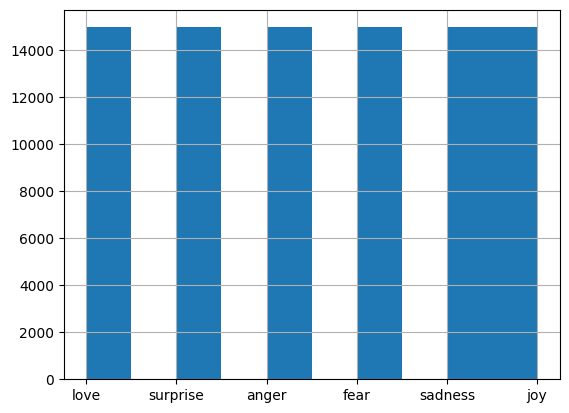

In [10]:
overall_df['emotion'].hist()

In [11]:
X = list(overall_df['text'])
y = list(overall_df['emotion'])

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
clf = GraphClassifier()
clf.fit(X_train, y_train, unique_labels, len(X))

execution time: 689.0844585895538


In [17]:
from tqdm import tqdm
from sklearn.metrics import recall_score, accuracy_score

def calculate_metrics(classifier, data, y_vals):
    y_pred = []

    for i in tqdm(range(len(data))):
        res = classifier.predict(data[i])
        y_pred.append(res)
        #if res == y_vals[i]:
        #    correct_count += 1
    
    accuracy = accuracy_score(y_vals, y_pred)
    recall = recall_score(y_vals, y_pred, average='macro')
    print("Точность:", accuracy)
    print("Полнота:", recall)

In [18]:
calculate_metrics(clf, X_test, y_test)

100%|██████████| 17967/17967 [04:07<00:00, 72.63it/s]


Точность: 0.8142706072243557
Полнота: 0.8144361853494094


<Axes: >

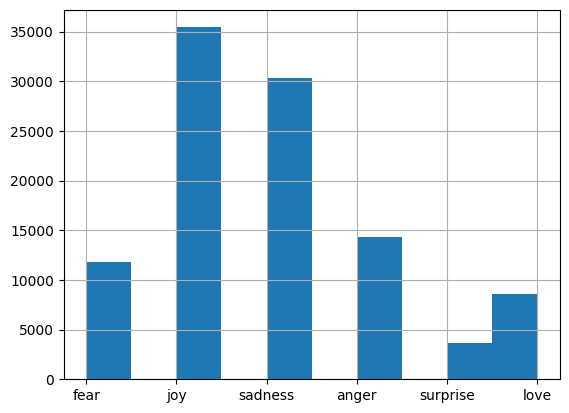

In [19]:
df2 = data.sample(frac=0.25)
df2['emotion'].hist()

In [21]:
X = list(df2['text'])
y = list(df2['emotion'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = GraphClassifier()
clf.fit(X_train, y_train, unique_labels, len(X))

execution time: 788.3336231708527


In [22]:
calculate_metrics(clf, X_test, y_test)

100%|██████████| 20841/20841 [04:42<00:00, 73.78it/s]


Точность: 0.640564272347776
Полнота: 0.40460852665999053
